In [1]:
import numpy as np
import copy
import pylab

# Applying Kullback Leibler

### Information entropy from probability distributions

Recall from [1] and [2] the form of information entropy for a random variable $X$ with distribution $P(x)$ over a (measurable) space $x \in \mathcal{X}$

$ I(P) = \log_2 \left( \frac{1}{P(X)} \right) $,

$ H(P) = - \sum_{x \in \mathcal{X}} P(x) \log_2 P(x) $

or more generally

$ H(P) = \mathbb{E}_{X\sim P} [ - \log_2 P(X) ] = \mathbb{E}_{X\sim P} [ I(X) ]$ 

$H(P)$ represents the 'uncertainty' of $X$, or the rate of generating information from an information source $X$. $I(P)$ represents the information content of an event from $X$. In the context of messaging, $I(P)$ represents the minimum length of the message (in bits) to transmit the information content of the message, and $H(P)$ is the expected length of a message.

For a continuous random variable $X$ with probability density function $p(x)$ over a continuous space $x \in \mathcal{X}$, one can use differential entropy [4], which is NOT a $n\to\infty$ limit of information entropy 

$ H(p) = \int_\mathcal{X} dx p(x) \log_2 p(x) $

### Cross entropy from probability distributions

The above definitions take into account only a single distribution over $X$. In practice, there may be multiple distributions over $X$, in particular an estimate (given a certain amount of evidence) of the distribution over $X$. Cross entropy allows extending the definitions of entropy to multiple distributions over the same random variable.

Suppose now that messages/information content are generated by a sender obeying another distribution $Q(x)$. One then has

$ I(Q) = \log_2 \left( \frac{1}{Q(X)} \right) $

However, the true distribution is $P(X)$. This means that the expected message length to correctly convey the information is

$ H(P,Q) := \mathbb{E}_{X\sim P} [ I(Q) ] = - \sum_{x \in \mathcal{X}} P(x) \log_2 Q(x) $

The cross entropy is useful for considering the discrepancy between a true distribution, $P(X)$, and some candidate or estimated distribution $Q(X)$ that one might be working with. It represents the 'uncertainty' of $X$ when one is using a presumed distribution $Q(X)$. Some good exploratory examples of the cross-entropy are available here [5]. Using the cross-entropy for machine learning (where, by a mild abuse of definition, P is a delta function distribution obtained from the training label, and Q are the normalised output weights of the ML algo that are not necessarily a probability distribution) is described here [8]. The extra uncertainty that arises over $H(P)$ can be used to define a quantity; namely the Kullback-Leibler divergence

$ D_{KL}(P||Q) := H(P,Q) - H(P) = \sum_{x \in \mathcal{X}} P(x) \log_2 \left(\frac{P(x)}{Q(x)}\right) = \sum_{x \in \mathcal{X}} P(x) \log_2 P(x) - P(x) \log_2 Q(x) $

By Gibbs' inequality [6], one finds that $ D_{KL}(P||Q) \geq 0 $ and $ D_{KL}(P||Q) = 0 $ if and only if $ P = Q $. $D_{KL}$ gives some kind of distance of how far $Q$ is from $P$, although does not form a distance metric, but does form a statistical divergence [7].

In [2]:
def simple_kl_div(p: np.array, q: np.array) -> float:
    return  np.sum(np.array(p) * np.log2(np.array(p)/np.array(q)))

In [3]:
n_class = 20
p = np.random.random(n_class)
p /= np.sum(p)
q = np.random.random(n_class)
q /= np.sum(q)
print(f"KL divergence of a distribution from itself = {simple_kl_div(p, p)}")
print(f"KL divergence of a distribution from another = {simple_kl_div(p, q)}")

KL divergence of a distribution from itself = 0.0
KL divergence of a distribution from another = 0.36583589129710303


### Using KL divergence in practice

Whilst the continuous and discrete forms can be used on theoretical distributions, often the discrete form is applied (on probability mass functions) to an empirical distribution, and/or a binned distribution. There are some issues in direct calculation, since the formula contains a logarithm that can blow up at zero. In general, the discrete form is fairly easy to apply (see simple_kl_div above), unless there are any $x_i$ such that $Q(x_i) = 0$ and $P(x_i) \neq 0$. The cases of $P(x_i) = 0$ are easy to address, since the logarithm containing $P(x)$ is multiplied by $P(x)$, and

$ \lim_{x \rightarrow 0+} x \log x = 0  $

In [4]:
def p_regularized_kl_div(p: np.array, q: np.array, p_eps: float=1.0e-16) -> float:
    """ p - array of length 'd' representing a true discrete probability distribution over d outcomes
        q - array of length 'd' representing a postulated discrete probability distribution over d outcomes
        p_eps - in calculating H(P), a regularization term to allow p_i log p_i to evaluate to zero whenever
                p_i < p_eps; here just to stop log p_i blowing up
                
        returns D_KL(P||Q) = H(P,Q) - H(P)
    """
    # for very small p, remove values that will not contribute to the H(P) sum
    # since lim (x -> 0+) x log x = 0, and a direct eval of log 0 will blow up
    p_reduced = [x for x in p if x > p_eps]
    h_p = - np.sum(np.array(p_reduced) * np.log2(np.array(p_reduced)))
    # perform naive calculation for H(P,Q)
    h_pq = - np.sum(np.array(p) * np.log2(np.array(q)))
    return h_pq - h_p

p[0] = 0.0  # put in a pathological 0 for p
p /= np.sum(p)
print(f"KL divergence of a distribution from another = {p_regularized_kl_div(p, q)}")

KL divergence of a distribution from another = 0.4635614335130569


The blow up from $\{x_i | Q(x_i) = 0, P(x_i) \neq 0\}$ is, from a theoretical perspective, perhaps unsurprising. $Q(x_i) = 0$ means that the assumed distribution asserts that $x_i$ can never happen. However, $P(x_i) \neq 0$ means that in truth $x_i$ can happen, revealing an 'infinite' amount of 'uncertainty' or 'surprise' around $x_i$. This means that something will have to be done to the assumed distribution $Q$ in order to get well-defined answers.

### Applying smoothing to the Q distribution

'Smoothing' on an array is a generic term for removing higher frequency components. In general, it may or may not be a good idea, depending on the domain.

Laplace/Lidstone/additive smoothing [9] is a method that can be applied to a distribution over a categorical dataset, which comes from Laplace's sunrise problem, of our observation samples always have the sun rising the next day; what happens if the sun does not rise on some day in the future?

In [5]:
def kl_div(
    p: np.array, 
    q: np.array, 
    p_eps: float=1.0e-16, 
    q_smoothing: str=None, 
    n_sample: int=None, 
    additive_smoothing_alpha: float=1.0
) -> float:
    """ p - array of length 'n_class' representing a true discrete probability distribution over d outcomes
        q - array of length 'n_class' representing a postulated discrete probability distribution over d outcomes
        p_eps - in calculating H(P), a regularization term to allow p_i log p_i to evaluate to zero whenever
                p_i < p_eps; here just to stop log p_i blowing up
        q_smoothing: type of smoothing to apply to q distribution
        n_sample: the number of samples involved in calculating the empirical distribution q
        additive_smoothing_alpha: alpha to use in smoothing https://en.wikipedia.org/wiki/Additive_smoothing
                                  actual value to use is contentious, although 1 tends to be the accepted value.
                                  In practice, the additive sampling is a function of
                                  (additive_smoothing_alpha/n_sample)

        returns D_KL(P||Q) = H(P,Q) - H(P)
    """
    n_class = len(p)
    if len(q) != n_class:
        raise ValueError(f"p and q must be of the same length, len(p) = {len(p)}, len(q) = {len(q)}")
    # for very small p, remove values that will not contribute to the H(P) sum
    # since lim (x -> 0+) x log x = 0, and a direct eval of log 0 will blow up
    p_reduced = [x for x in p if x > p_eps]
    h_p = - np.sum(np.array(p_reduced) * np.log2(np.array(p_reduced)))
    # perform naive calculation for H(P,Q)
    if q_smoothing is None:
        pass
    elif q_smoothing == "additive":
        # assume that q has already been normalised from an empirical distribution, so undo that
        q_smoothed = n_sample * q
        # apply additive smoothing formula
        q_smoothed = (q_smoothed + additive_smoothing_alpha) / (n_sample + additive_smoothing_alpha * n_class)
        q = q_smoothed
    else:
        raise ValueError(f"unknown q-smoothing requested: {q_smoothing}")
    h_pq = - np.sum(np.array(p) * np.log2(np.array(q)))
    return h_pq - h_p

In [6]:
p_pathological = copy.deepcopy(p)
p_pathological[0] = 0.0  # put in a pathological 0 for p
p_pathological /= np.sum(p_pathological)
print(f"KL divergence of a distribution from another = {kl_div(p_pathological, q)}")

KL divergence of a distribution from another = 0.4635614335130569


In [7]:
q_pathological = copy.deepcopy(q)
q_pathological[0] = 0.0 # put in a pathological 0 for q
q_pathological /= np.sum(q_pathological)
print(f"KL divergence of a distribution from another = {kl_div(p_pathological, q_pathological, q_smoothing='additive', n_sample=100000)}")

KL divergence of a distribution from another = 0.3880334540041659


### Analysing data drift

In a deployment or monitoring scenario, oen might be interested to see if the presumed distribution (derived from some training data) is a reasonable approximation to a true distribution. This measure ways could change over time.

In practice, the ways of performing this kind of monitoring are:
- to calculate a Kullback Leibler divergence on features of the training data from the most recent feed of data
- to train a binary classifier on features from the training data, and the most recent data feed, and look at the accuracy of the classifier

As a play example, consider the first method on some data that drifts over days.

In [8]:
def get_binned_samples(loc: float, n_sample: int, bin_width: float=0.1, scale: float=1.0) -> dict[float, float]:
    """ loc - centre of normal distribution
        n_sample - number of samples to generate
        bin_width - width of the bins to make the histogram
        scale - standard deviation of normal distribution
        
        returns a dict<bin value, frequency of bin>
    """
    samples = np.random.normal(loc=loc, scale=scale, size=n_sample)
    binned_samples = {}
    for sample in samples:
        bin = int(sample / bin_width) * bin_width
        binned_samples[bin] = binned_samples.get(bin, 0) + 1
    if 0 in binned_samples.keys():
        binned_samples[0] /= 2  # overcounting of zero bin
    return binned_samples

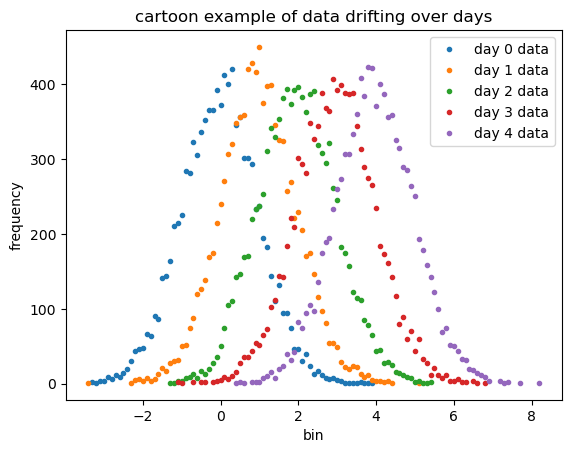

In [9]:
n_sample = 10000
dayN_datas = []
for i_day, loc in enumerate(np.arange(0,5,1.0)):
    this_samples = get_binned_samples(loc, n_sample)
    pylab.plot(this_samples.keys(), this_samples.values(), '.', label=f"day {i_day} data")
    dayN_datas.append(this_samples)
pylab.xlabel("bin")
pylab.ylabel("frequency")
pylab.title("cartoon example of data drifting over days")
pylab.legend()

As an exercise in quantifying the drift, one can calculate the Kullback-Leibler divergence of the empirical distribution from day 0 from the empirical distribution from day N. This might be useful in, say, an MLOps context, where the data from day 0 has been used to train a model, and one might wonder when the model should be retrained.

In [10]:
day0_data = dayN_datas[0]
for i_day, dayI_data in enumerate(dayN_datas):
    bins = sorted(list(set(day0_data.keys()) | set(dayI_data.keys())))
    # the assumed distribution is the day 0 data, as this data may have been used to train a model
    q = np.zeros(len(bins))
    for k, v in day0_data.items():
        q[bins.index(k)] = v
    q /= np.sum(q)
    # the closest we have to a true distribution on day I is the data collected from day I
    p = np.zeros(len(bins))
    for k, v in dayI_data.items():
        p[bins.index(k)] = v
    p /= np.sum(p)
    kl = kl_div(p, q, q_smoothing='additive', n_sample=n_sample, additive_smoothing_alpha=1.0)
    print(f"KL divergence of q (day 0) from p (day {i_day}) = {kl}")
    

KL divergence of q (day 0) from p (day 0) = 0.000534790208678082
KL divergence of q (day 0) from p (day 1) = 0.7192455915400098
KL divergence of q (day 0) from p (day 2) = 2.619395803214064
KL divergence of q (day 0) from p (day 3) = 4.958877198342277
KL divergence of q (day 0) from p (day 4) = 6.818006524629945


One can see that the KL divergence gives an indication of how far the data has drifted from day to day. Altering the smoothing alpha does have an impact on the results (something to be aware of, and not uncommon with a hard 'epsilon' style regularization), although maintains the same trend.

### References

[1] Shannon, C. ["A mathematical theory of communication"](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)

[2] Wikipedia, ["Entropy"](https://en.wikipedia.org/wiki/Entropy_(information_theory))

[3] Wikipedia, ["Conditional Entropy"](https://en.wikipedia.org/wiki/Conditional_entropy)

[4] Wikipedia, ["Differential Entropy"](https://en.wikipedia.org/wiki/Differential_entropy)

[5] Towards Data Science, ["Entropy, Cross-Entropy, and KL-Divergence Explained!"](https://towardsdatascience.com/entropy-cross-entropy-and-kl-divergence-explained-b09cdae917a)

[6] Wikipedia, ["Gibbs' inequality"](https://en.wikipedia.org/wiki/Gibbs%27_inequality#Proof)

[7] Wikipedia, ["Divergence_(statistics)"](https://en.wikipedia.org/wiki/Divergence_(statistics))

[8] Medium, ["Loss Functions in Machine Learning"](https://medium.com/swlh/cross-entropy-loss-in-pytorch-c010faf97bab)

[9] Wikipedia, ["Additive smoothing"](https://en.wikipedia.org/wiki/Additive_smoothing)